# Exploratory Data Analysis - Ookla for Good Dataset

This notebook contains exploratory data analysis of Ookla dataset available [here](https://registry.opendata.aws/speedtest-global-performance/). Primary aim here is to understand the structure of the data, its granularity and usability along with other datasets for upcoming hackathon. Also, a preliminary visualization is created to understand what can be possibly done using this dataset.

### Data Structure
The dataset contains data from speedtests done by the users around the world in year 2020. It is aggregated by a tile (an area of the earth), quarter of the year and the type of internet connection (i.e. `fixed` or `mobile`). In other words, one file for each quarter and type of connection is available where each row contains an aggregate data for a tile. Data is available in form of shapefiles as well as parquet format, making it in total 16 files. All the files are stored in an AWS S3 bucket. List of all the files in XML format can be accessed [here](https://ookla-open-data.s3-us-west-2.amazonaws.com/).

### Accessing the Files
There are several different ways to access the files. The easiest way is to download using url. File names are structured as follows:

https://ookla-open-data.s3.amazonaws.com/{filetype}/performance/type={type}/year=2020/quarter={quarter}/{date}_performance_{type}_tiles.{extension}
     
where 
* `filetype` can be `shapefiles` or `parquet`
* `type` can be `fixed` or `mobile` 
* `quarter` can be any integer from 1 to 4 (both inclusive) 
* `date` in the file name is the start date of the quarter. Note that `date` should match the corresponding `quarter` as shown in the table below:
     | quarter | date |
     | --- | --- | 
     | 1 | 2020-01-01 | 
     | 2 | 2020-04-01 | 
     | 3 | 2020-07-01 | 
     | 4 | 2020-10-01 | 
* `extension` can be `zip` and `parquet` for `shapefiles` and `parquet` files respectively.
     
For example, if you want to download *shapefiles* for *fixed* connections from *3rd* quarter of 2020, url will look like this: https://ookla-open-data.s3.amazonaws.com/shapefiles/performance/type=fixed/year=2020/quarter=3/2020-07-01_performance_fixed_tiles.zip
     
or, if you want to download *parquet* for *mobile* connections from *2nd* quarter of 2020, url will look like this:      https://ookla-open-data.s3.amazonaws.com/parquet/performance/type=mobile/year=2020/quarter=2/2020-04-01_performance_mobile_tiles.parquet
 
Note that both parquet and shapefiles contain the same data. Let us play with the data now. 

### Additional Information
This [github repo](https://github.com/teamookla/ookla-open-data) contains detailed information about the dataset including other ways to download it. It also contains tutorials on how the data can be used. This notebook is also inspired by one of the tutorials.

---

## Download Speed Map for Rural Municipalities in AB



### Import Libraries

In [1]:
%matplotlib inline

from datetime import datetime
import geopandas as gp
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from shapely.geometry.polygon import Polygon
from shapely import wkt
from adjustText import adjust_text


### Import Data

As mentioned earlier in the instructions, use the url to download the required data. In this notebook, we will be working mostly with the shapefiles containing speedtest results for *fixed* connections from Q2-2020. Since its a massive dataset, it will take few minutes to load the shapefiles.

In [2]:
tiles = gp.read_file('2020-04-01_performance_fixed_tiles.zip')

In [3]:
tiles.head()

,quadkey,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,geometry
0,1321222233020202,144116,125751,3,7330,1324,"POLYGON ((113.55469 22.16197, 113.56018 22.161..."
1,1230231303303002,89763,52939,42,726,137,"POLYGON ((55.41504 25.27947, 55.42053 25.27947..."
2,0313131210131030,62657,15479,19,271,40,"POLYGON ((-1.79077 51.55658, -1.78528 51.55658..."
3,0213330110110321,98061,11842,19,2,1,"POLYGON ((-93.22449 45.06576, -93.21899 45.065..."
4,3100130032202231,15167,7287,8,674,122,"POLYGON ((107.59460 -6.91552, 107.60010 -6.915..."


In [4]:
tiles.shape

(6938763, 7)

We can see that it is a massive dataset with ~7 million rows where each row represents a tile. Various columns here are:
* `quadkey` - a unique number representing a tile
* `avg_d_kbps` - average download speed (kbps)
* `avg_d_kbps` - average upload speed (kbps)
* `avg_lat_ms` - average latency (ms)
* `tests` - number of speedtests
* `devices` - number of unique devices from which speedtests were performed
* `geometry` - polygon object with coordinates in [WKT](https://en.wikipedia.org/wiki/Well-known_text_representation_of_geometry) format

Note that all other files in the dataset have similar columns.

### Get Rural Municipality Boundaries

Now we need to get shapefiles for areas in AB which are classified as rural municipalities. [U of L library](https://library.ulethbridge.ca/spatial_data/alberta_data) hosts large amount of spatial data. Dataset used in this notebook can be downloaded from [here](https://www.altalis.com/map;id=113). You may need to make an account to download the data and then a link to download the dataset will be sent to your email. This process is completely free of cost. 

Note that this dataset contains shapefiles for all the categories of habitats such as towns, cities, villages, hamlets etc. So make sure to get the files pertaining to rural municipalities (i.e. `RURAL.*`) and put them in a folder which is in the same directory as this notebook.

In [5]:
# Rural municipality data
counties = gp.read_file('AB_rural_municipalities_shape_files/')

In [6]:
# Reproject to match the tiles
ab_counties = counties.to_crs(4326) 

In [7]:
ab_counties.head()

,RURAL_ID,PID,GEONAME,GEOCODE,geometry
0,1,29860,MUNICIPAL DISTRICT OF ACADIA NO. 34,0001,"POLYGON ((-110.05165 51.27041, -110.05136 51.2..."
1,2,29863,ATHABASCA COUNTY,0012,"POLYGON ((-113.68568 54.53633, -113.68569 54.5..."
2,3,29864,COUNTY OF BARRHEAD NO. 11,0015,"POLYGON ((-114.05164 53.92673, -114.05164 53.9..."
3,4,29865,BEAVER COUNTY,0020,"POLYGON ((-113.00114 53.29425, -113.00114 53.2..."
4,5,29869,MUNICIPAL DISTRICT OF BONNYVILLE NO. 87,0036,"POLYGON ((-110.35209 53.82412, -110.35207 53.8..."


In [8]:
ab_counties.shape

(80, 5)

### Join Tiles to Municipalities

Now the tiles from ookla data is joined to the AB municipalities. If this join takes few minutes, don't get surprised. 

In [9]:
# Join based on the geometry of tiles and municipalities
tiles_in_ab_counties = gp.sjoin(tiles, ab_counties, how="inner", op='intersects')

In [10]:
# convert to Mbps for easier reading
tiles_in_ab_counties['avg_d_mbps'] = tiles_in_ab_counties['avg_d_kbps'] / 1000
tiles_in_ab_counties['avg_u_mbps'] = tiles_in_ab_counties['avg_u_kbps'] / 1000

In [11]:
tiles_in_ab_counties.head()

,quadkey,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,geometry,index_right,RURAL_ID,PID,GEONAME,GEOCODE,avg_d_mbps,avg_u_mbps
81,0212113123101220,54680,7051,12,8,4,"POLYGON ((-113.33496 53.52072, -113.32947 53.5...",40,41,29839,STRATHCONA COUNTY,0302,54.680,7.051
7887,0212113123110323,107067,14289,11,55,15,"POLYGON ((-113.26355 53.51745, -113.25806 53.5...",40,41,29839,STRATHCONA COUNTY,0302,107.067,14.289
8691,0212113132221013,17595,2306,28,59,5,"POLYGON ((-113.14270 53.38005, -113.13721 53.3...",40,41,29839,STRATHCONA COUNTY,0302,17.595,2.306
24210,0212113123103120,60560,9674,28,6,2,"POLYGON ((-113.31299 53.50765, -113.30750 53.5...",40,41,29839,STRATHCONA COUNTY,0302,60.560,9.674
42494,0212113121323312,96674,18516,9,30,7,"POLYGON ((-113.30200 53.55010, -113.29651 53.5...",40,41,29839,STRATHCONA COUNTY,0302,96.674,18.516


### Make a Table of Top 5 and Bottom 5 Municipalities in Terms of Download Speed

Here we will make a table containing list of 5 municipalities with highest and lowest download speed.

In [12]:
# Calculate average download/upload speed for a given municipality - it is weighted by number of tests
county_stats = (
    tiles_in_ab_counties.groupby(["GEONAME"])
    .apply(
        lambda x: pd.Series(
            {"avg_d_mbps_wt": np.average(x["avg_d_mbps"], weights=x["tests"])}
        )
    )
    .reset_index()
    .merge(
        tiles_in_ab_counties.groupby(["GEONAME"])
        .agg(tests=("tests", "sum"))
        .reset_index(),
        on=["GEONAME"],
    )
)

In [13]:
table_stats = (
    county_stats.nlargest(5, "avg_d_mbps_wt")
    .append(
        county_stats.nsmallest(5, "avg_d_mbps_wt")
    )
    .sort_values("avg_d_mbps_wt", ascending=False)
    .round(2) # round to 2 decimal places for easier reading
)

In [14]:
header = ["Municipality", "Avg download speed (Mbps)", "Tests"]

table_stats.rename(columns=dict(zip(table_stats.columns, header)))

,Municipality,Avg download speed (Mbps),Tests
56,MUNICIPALITY OF CROWSNEST PASS,134.89,239
62,REGIONAL MUNICIPALITY OF WOOD BUFFALO,127.92,6253
37,LETHBRIDGE COUNTY,122.32,8337
22,CYPRESS COUNTY,119.37,6008
63,ROCKY VIEW COUNTY,114.78,21614
46,MUNICIPAL DISTRICT OF OPPORTUNITY NO. 17,8.54,282
27,I.D. NO. 349,8.00,6
25,I.D. NO. 12 (JASPER NATIONAL PARK),5.26,4
7,CLEAR HILLS COUNTY,5.08,59
3,BIRCH HILLS COUNTY,3.43,83


---

## Map for Download Speed in Rural Municipalities

Here a choropleth map for AB municipalities is created which shows the download speed range in which it falls. 

In [15]:
county_data = ab_counties[['GEONAME', 'geometry']].merge(county_stats, on='GEONAME').to_crs(3401)

In [16]:
labels = ["0 to 25 Mbps", "25 to 50 Mbps", "50 to 100 Mbps", "100 to 150 Mbps", "150 to 200 Mbps"]

county_data['group'] = pd.cut(
    county_data.avg_d_mbps_wt, 
    (0, 25, 50, 100, 150, 200), 
    right=False, 
    labels = labels
)

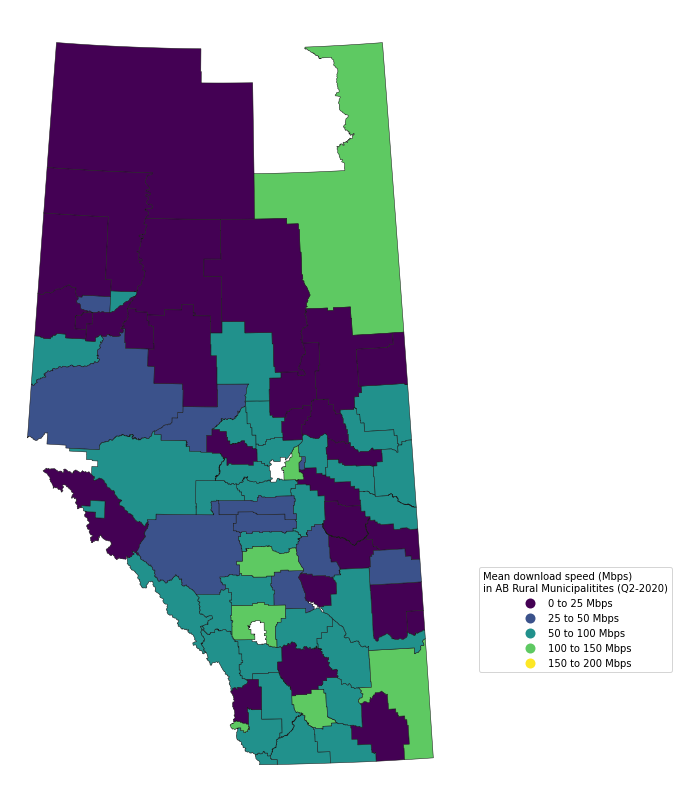

In [32]:
fig, ax = plt.subplots(1, figsize=(8, 16))

county_data.plot(
    column="group", cmap="viridis", linewidth=0.5, ax=ax, edgecolor="0.1", legend=True
)

ax.axis("off")

leg = ax.get_legend()
leg.set_bbox_to_anchor((1.5, 0.3))
leg.set_title("Mean download speed (Mbps)\nin AB Rural Municipalitites (Q2-2020)")


Since the major cities are not available in the shapefiles for rural municipalities, they are colored white in this map. They can be easily appended to the dataframe by considering shapefiles for cities.

### Mobile Data
Here a snapshot of speedtests for mobile connections is presented. Note the similar columns as other files.

In [18]:
tiles = gp.read_file('2020-04-01_performance_mobile_tiles.zip')

In [19]:
tiles.head()

,quadkey,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,geometry
0,1203022122320032,28772,3165,34,8,1,"POLYGON ((24.09302 49.88402, 24.09851 49.88402..."
1,0313113213321131,20782,10180,54,2,2,"POLYGON ((-1.49963 52.95526, -1.49414 52.95526..."
2,1221210331312333,22690,22416,449,6,2,"POLYGON ((30.88806 29.92161, 30.89355 29.92161..."
3,1200312211223323,54493,4635,21,2,2,"POLYGON ((18.00110 59.35840, 18.00659 59.35840..."
4,0302233220203221,90669,6576,21,1,1,"POLYGON ((-81.51306 41.31908, -81.50757 41.319..."


In [20]:
tiles.shape

(4075861, 7)

### Mobile Connection - Parquet
Here a snapshot of data for mobile connections from parquet file is presented. The data is same as the shapefiles.

In [24]:
mobile_parquet = pd.read_parquet('2020-04-01_performance_mobile_tiles.parquet')

In [25]:
mobile_parquet.head()

,quadkey,tile,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices
0,1203022122320032,"POLYGON((24.093017578125 49.8840172172466, 24....",28772,3165,34,8,1
1,0313113213321131,"POLYGON((-1.4996337890625 52.9552569784547, -1...",20782,10180,54,2,2
2,1221210331312333,"POLYGON((30.8880615234375 29.9216133196956, 30...",22690,22416,449,6,2
3,1200312211223323,"POLYGON((18.0010986328125 59.3583959060394, 18...",54493,4635,21,2,2
4,0302233220203221,"POLYGON((-81.5130615234375 41.3190756229514, -...",90669,6576,21,1,1


In [26]:
mobile_parquet.shape

(4075861, 7)

### Fixed Connection - Parquet
Here a snapshot of data for fixed connections from parquet file is presented. The data is same as the shapefiles.

In [21]:
fixed_parquet = pd.read_parquet('2020-04-01_performance_fixed_tiles.parquet')

In [22]:
fixed_parquet.head()

,quadkey,tile,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices
0,1321222233020202,"POLYGON((113.5546875 22.161970614368, 113.5601...",144116,125751,3,7330,1324
1,1230231303303002,"POLYGON((55.4150390625 25.2794707340818, 55.42...",89763,52939,42,726,137
2,0313131210131030,"POLYGON((-1.790771484375 51.5565821857625, -1....",62657,15479,19,271,40
3,0213330110110321,"POLYGON((-93.2244873046875 45.0657615477031, -...",98061,11842,19,2,1
4,3100130032202231,"POLYGON((107.594604492188 -6.91552057304965, 1...",15167,7287,8,674,122


In [23]:
fixed_parquet.shape

(6938763, 7)

### Converting Parquet Data into Geopandas Dataframe
This is one of the several ways to convert data from parquet files into geopandas dataframe.

In [27]:
fixed_parquet = pd.read_parquet('2020-04-01_performance_fixed_tiles.parquet')

In [28]:
# Convert geometry to WKT object
fixed_parquet['geometry'] = fixed_parquet['tile'].apply(wkt.loads)
fixed_parquet.drop(columns=['tile'], inplace=True)

In [29]:
# Create a geopandas dataframe with same CRS projection as other data
fp = gp.GeoDataFrame(fixed_parquet, crs=4326, geometry='geometry')

In [30]:
fp.head()

,quadkey,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,geometry
0,1321222233020202,144116,125751,3,7330,1324,"POLYGON ((113.55469 22.16197, 113.56018 22.161..."
1,1230231303303002,89763,52939,42,726,137,"POLYGON ((55.41504 25.27947, 55.42053 25.27947..."
2,0313131210131030,62657,15479,19,271,40,"POLYGON ((-1.79077 51.55658, -1.78528 51.55658..."
3,0213330110110321,98061,11842,19,2,1,"POLYGON ((-93.22449 45.06576, -93.21899 45.065..."
4,3100130032202231,15167,7287,8,674,122,"POLYGON ((107.59460 -6.91552, 107.60010 -6.915..."


In [31]:
fp.dtypes

quadkey         object
avg_d_kbps       int64
avg_u_kbps       int64
avg_lat_ms       int64
tests            int64
devices          int64
geometry      geometry
dtype: object

In [33]:
some = gp.sjoin(fp, ab_counties, how="inner", op='intersects')

### More Tutorials

Don't forget more Ookla tutorials in R and Python programming languages can be found [here](https://github.com/teamookla/ookla-open-data/tree/master/tutorials).